Filter samples by sharpness level

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
fcnt = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        fcnt += 1
        if fcnt < 10 or fcnt > 2190:
            print(os.path.join(dirname, filename))
print(fcnt)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full.csv
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Laurence_Fishburne_4.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Kate_Capshaw_2.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Larry_Nichols_0.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Norman_Mineta_5.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Kweisi_Mfume_1.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/Oliver_Phelps_0.npz
/kaggle/input/youtube-faces-with-facial-keypoints/youtube

In [3]:
import torch
import torchvision

In [4]:
#!pip install torchinfo

In [5]:
#from torchinfo import summary

In [6]:
#model = torch.load('/kaggle/input/faceid-model/faceid-model-0.0011414959120764233.pt', map_location=torch.device('cpu'))
#summary(model, (1, 1, 224, 224))

In [7]:
!mkdir -pv /kaggle/temp
!rm -Rf /kaggle/temp/*
!cp -as /kaggle/input/youtube-faces-with-facial-keypoints /kaggle/temp/
!mv /kaggle/temp/youtube-faces-with-facial-keypoints/*/*/*.npz /kaggle/temp/youtube-faces-with-facial-keypoints/
!ls /kaggle/temp/youtube-faces-with-facial-keypoints/ | wc

   2199    2199   45153


In [8]:
data_dir = '/kaggle/temp/youtube-faces-with-facial-keypoints'
#data_dir = '/kaggle/input/faceid-preprocessed'

In [9]:
df = pd.read_csv(f'{data_dir}/youtube_faces_with_keypoints_full.csv')
df

videoID      personName  imageHeight  imageWidth  \
0      Alison_Lohman_0   Alison_Lohman        228.0       213.0   
1      Alison_Lohman_1   Alison_Lohman        248.0       201.0   
2      Alison_Lohman_2   Alison_Lohman        335.0       308.0   
3      Alison_Lohman_3   Alison_Lohman        151.0       110.0   
4      Alison_Lohman_4   Alison_Lohman        236.0       228.0   
...                ...             ...          ...         ...   
2189    Yossi_Beilin_3    Yossi_Beilin        240.0       243.0   
2190      Zahir_Shah_0      Zahir_Shah        196.0       200.0   
2191      Zahir_Shah_1      Zahir_Shah        240.0       293.0   
2192  Zoran_Djindjic_0  Zoran_Djindjic        230.0       237.0   
2193  Zoran_Djindjic_2  Zoran_Djindjic        131.0       115.0   

      videoDuration  averageFaceSize  numVideosForPerson  
0             240.0        90.150000                 6.0  
1              79.0       108.417722                 6.0  
2             136.0       122.161765                 6.0  
3              53.0        58.000000                 6.0  
4             147.0        91.680272                 6.0  
...             ...              ...                 ...  
2189          240.0       110.258333                 2.0  
2190          143.0        93.944056                 2.0  
2191          240.0       155.495833                 2.0  
2192          240.0        98.908333                 2.0  
2193          240.0        59.554167                 2.0  

[2194 rows x 7 columns]

In [10]:
import PIL
import cv2

class NormalizeTransform:
    def __init__(self, ratio=0.333):
        self.ratio = ratio

        self.jawPoints          = [ 0,17]
        self.rigthEyebrowPoints = [17,22]
        self.leftEyebrowPoints  = [22,27]
        self.noseRidgePoints    = [27,31]
        self.noseBasePoints     = [31,36]
        self.rightEyePoints     = [36,42]
        self.leftEyePoints      = [42,48]
        self.outerMouthPoints   = [48,60]
        self.innerMouthPoints   = [60,68]

        self.norm_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.functional.autocontrast,
            torchvision.transforms.functional.to_grayscale,
            torchvision.transforms.ToTensor(),
        ])

    def __call__(self, data, landmarks):
        data = self.face_transform(data, landmarks)
        img = PIL.Image.fromarray(data)
        data = self.norm_transform(img)
        return data

    def face_transform(self, data, landmarks):
        # see FaceId-Normalization.ipynb
        pt1 = self.avg(landmarks[self.leftEyePoints[0]:self.leftEyePoints[1]])
        pt2 = self.avg(landmarks[self.outerMouthPoints[0]:self.outerMouthPoints[1]])
        pt3 = self.avg(landmarks[self.rightEyePoints[0]:self.rightEyePoints[1]])
        src_pts = np.float32([pt1, pt2, pt3])
        dst_pts = np.float32([
            [data.shape[0]*self.ratio, data.shape[1]*self.ratio],
            [data.shape[0]/2, data.shape[1]*(1-self.ratio)],
            [data.shape[0]*(1-self.ratio), data.shape[1]*self.ratio]
        ])
        M = cv2.getAffineTransform(src_pts, dst_pts)
        data = cv2.warpAffine(data, M, data.shape[:2])
        return data
    
    def avg(self, pts):
        x = sum(x for x,y in pts) / len(pts)
        y = sum(y for x,y in pts) / len(pts)
        return x, y

In [11]:
import random
import pickle

random.seed()

class YouTubeFacesDataset(torch.utils.data.Dataset):
    def __init__(self, df, folder = '.', transform = NormalizeTransform(),
                 cache_lim = 200,
                 preload = False, preprocess = False,
                 anchor_set_len = 1, positive_set_len = 1, negative_set_len = 1,
                 stochastic_set_fraction = 0.8):
        self.transform = transform
        self.cache = {}
        self.cache_lim = 0 if preload else cache_lim
        self.preprocessed_cache = {}
        self.data = {}
        for p in tqdm(df['personName'].unique(), desc='Loading data'):
            self.data[p] = []
            for fn, cnt in df[df['personName'] == p][['videoID', 'videoDuration']].values:
                fp = f'{folder}/{fn}.npz'
                cnt = int(cnt)
                self.data[p] += [(fp, i) for i in range(cnt)]
                if preload:
                    self.cache_lim += 1
                    imgs, lms = self._cache_get(fp)
                    assert imgs.shape[-1] == cnt
                    assert lms.shape[-1] == cnt
                if preprocess:
                    pfp = self._preprocess(fp)
                    imgs = self._load_preprocessed(pfp)
                    assert len(imgs) == cnt
                    self.preprocessed_cache[fp] = imgs
        self.persons = list(self.data.keys())
        self.neg_data = {}
        for p in self.persons:
            self.neg_data[p] = []
            for p_neg in self.persons:
                if p_neg == p:
                    continue
                self.neg_data[p] += self.data[p_neg]
        self.anchor_set_len = anchor_set_len
        self.positive_set_len = positive_set_len
        self.negative_set_len = negative_set_len
        self.stochastic_set_fraction = stochastic_set_fraction
    
    def resize(self, anchor_set_len = 1, positive_set_len = 1, negative_set_len = 1, stochastic_set_fraction = 0.8):
        self.anchor_set_len = anchor_set_len
        self.positive_set_len = positive_set_len
        self.negative_set_len = negative_set_len
        self.stochastic_set_fraction = stochastic_set_fraction
    
    def __len__(self):
        return len(self.persons) * self.anchor_set_len * self.positive_set_len * self.negative_set_len
    
    def __getitem__(self, index):
        p_i = index // self.negative_set_len // self.positive_set_len // self.anchor_set_len
        assert p_i >= 0
        assert p_i < len(self.persons)
        p = self.persons[p_i]
        if self.negative_set_len > len(self.neg_data[p]) * self.stochastic_set_fraction:
            negative_i = index % self.negative_set_len
            negative_i = negative_i % len(self.neg_data[p])
        else:
            negative_i = random.randint(0, len(self.neg_data[p]) - 1)
        assert negative_i >= 0
        assert negative_i < len(self.neg_data[p])
        if self.positive_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            positive_i = (index // self.negative_set_len) % self.positive_set_len
            positive_i = positive_i % len(self.data[p])
        else:
            positive_i = random.randint(0, len(self.data[p]) - 1)
        assert positive_i >= 0
        assert positive_i < len(self.data[p])
        if self.anchor_set_len > len(self.data[p]) * self.stochastic_set_fraction:
            anchor_i = (index // self.negative_set_len // self.positive_set_len) % self.anchor_set_len
            anchor_i = anchor_i % len(self.data[p])
        else:
            anchor_i = random.randint(0, len(self.data[p]) - 1)
        assert anchor_i >= 0
        assert anchor_i < len(self.data[p])
        return self._load(*self.data[p][anchor_i]), self._load(*self.data[p][positive_i]), self._load(*self.neg_data[p][negative_i])
    
    def _load(self, fp, i):
        if fp in self.preprocessed_cache:
            assert i < len(self.preprocessed_cache[fp]), (fp, i, len(self.preprocessed_cache[fp]))
            if self.preprocessed_cache[fp][i] is not None:
                return self.preprocessed_cache[fp][i]
        imgs, lms = self._cache_get(fp)
        assert i < imgs.shape[-1], (fp, i, imgs.shape[-1])
        data = imgs[:,:,:,i]
        assert i < lms.shape[-1], (fp, i, lms.shape[-1])
        lms = lms[:,:,i]
        if self.transform:
            data = self.transform(data, lms)
        return data
    
    def _cache_get(self, fp):
        if fp in self.cache:
            return self.cache[fp]
        if len(self.cache) > self.cache_lim:
            idx = random.randint(0, len(self.cache) - 1)
            key = list(self.cache.keys())[idx]
            del self.cache[key]
        d = np.load(fp)
        # trigger lazy loading
        self.cache[fp] = (d['colorImages'], d['landmarks2D'])
        return self.cache[fp]
    
    def _preprocess(self, fp):
        pfp = f'{fp}.pkl'
        if not os.path.exists(pfp):
            imgs, lms = self._cache_get(fp)
            d = [self._load(fp, i) for i in range(imgs.shape[-1])]
            with open(pfp, 'wb') as f:
                pickle.dump(d, f)
        return pfp
    
    def _load_preprocessed(self, pfp):
        with open(pfp, 'rb') as f:
            return pickle.load(f)

dataset = YouTubeFacesDataset(df, data_dir, cache_lim = 1)
len(dataset)

Loading data: 100%|██████████| 828/828 [00:02<00:00, 295.14it/s]


828

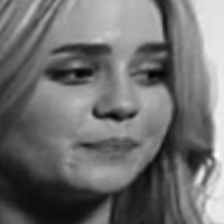

In [12]:
to_pil = torchvision.transforms.ToPILImage()
to_pil(dataset[0][0])

In [13]:
# https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
def get_sharpness_level(img):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(img, cv2.CV_32F).var()

0.00012507637
0.0002177589
0.00029199326
0.0006833294
0.000854796
0.000117955315
0.000117751515
0.0003674614
0.00021226107
0.00097032223


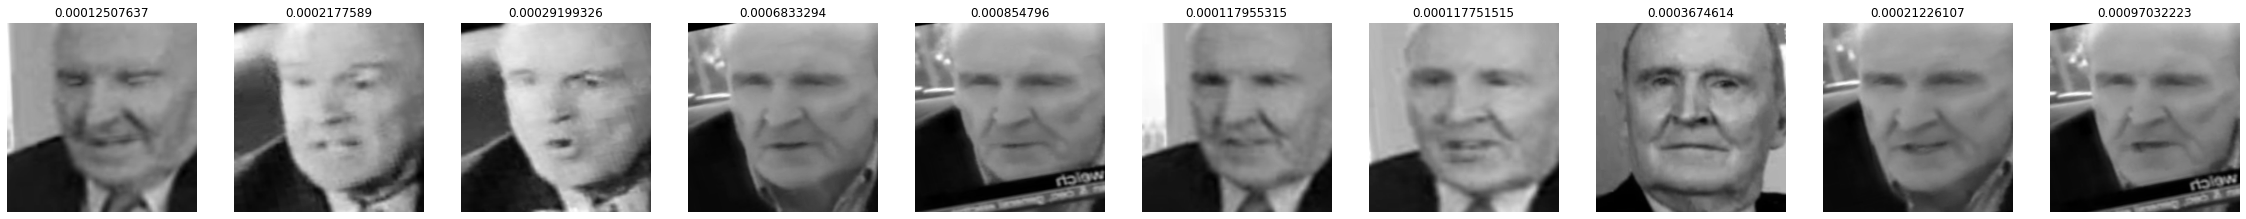

In [16]:
def print_sharpness_levels(img_id):
    cnt = 10
    _, axs = plt.subplots(nrows=1, ncols=cnt, figsize=(cnt*4, 1*4))
    for i in range(cnt):
        img = dataset[img_id][0].detach().reshape(224, 224).numpy()
        title = get_sharpness_level(img)
        plt.sca(axs[i])
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
        print(title)

print_sharpness_levels(80)

0.0002495116
0.00036062615
0.00062221865
0.00031656816
0.00021229226
0.00035686992
0.00037562387
0.0005593492
0.00023688431
0.00068425987


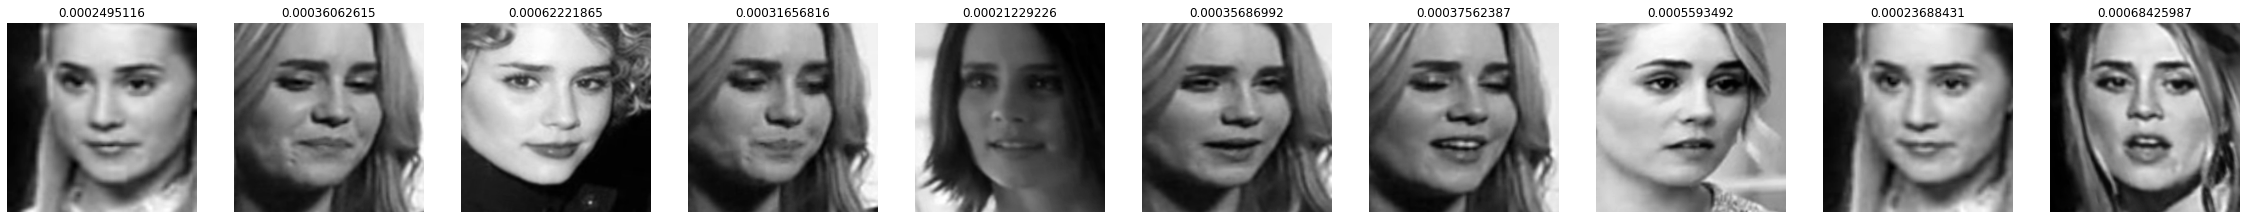

In [17]:
print_sharpness_levels(0)

In [18]:
def cos_similarity(v1, v2):
    val = np.inner(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    return val.reshape(-1)[0]

def euc_similarity(v1, v2):
    return np.linalg.norm(v1-v2)

In [19]:
def validate(model_f, cnt = 20, sharpness_level = 5e-4):
    model = torch.load(model_f, map_location=torch.device('cpu'))
    _, axs = plt.subplots(nrows=cnt, ncols=3, figsize=(3*4, cnt*4))
    for i in range(cnt):
        while True:
            idx = random.randint(0, len(dataset)-1)
            img1, img2, img3 = dataset[idx]
            if get_sharpness_level(img1.reshape(224, 224).detach().numpy()) > sharpness_level:
                continue
            if get_sharpness_level(img2.reshape(224, 224).detach().numpy()) > sharpness_level:
                continue
            if get_sharpness_level(img3.reshape(224, 224).detach().numpy()) > sharpness_level:
                continue
            break
        v1 = model(img1.reshape(1, 1, 224, 224)).detach().numpy()
        v2 = model(img2.reshape(1, 1, 224, 224)).detach().numpy()
        v3 = model(img3.reshape(1, 1, 224, 224)).detach().numpy()
        title = '%d %f %f %f %f %f %f' % (idx,
            euc_similarity(v1, v2), euc_similarity(v1, v3),
            cos_similarity(v1, v2), cos_similarity(v1, v3),
            np.vstack((v1, v2, v3)).min(), np.vstack((v1, v2, v3)).max())
        plt.sca(axs[i, 0])
        plt.imshow(img1.reshape(224, 224), cmap='gray')
        plt.axis('off')
        plt.sca(axs[i, 1])
        plt.imshow(img2.reshape(224, 224), cmap='gray')
        plt.axis('off')
        plt.title(title)
        plt.sca(axs[i, 2])
        plt.imshow(img3.reshape(224, 224), cmap='gray')
        plt.axis('off')
        print(title)

741 3.605057 9.568620 0.965223 0.627887 -4.926806 4.692506
47 4.566631 11.302146 0.849692 -0.117059 -4.066490 4.110906
806 5.379024 9.183702 0.657541 0.485676 -4.375238 4.042662
348 3.277931 7.984556 0.907212 0.451414 -3.806296 3.961654
39 3.308991 13.581720 0.963323 0.111233 -7.232232 3.488891
641 3.590445 11.870909 0.927658 0.057490 -5.152685 3.890839
405 2.772395 11.297544 0.966259 0.001677 -4.378921 4.506156
60 3.140048 9.120042 0.930118 0.083413 -3.462286 4.736318
564 2.147290 9.286543 0.926117 0.466152 -5.132891 4.595041
103 4.789389 4.956280 0.783711 0.686758 -4.113410 3.295477
288 1.938922 6.733237 0.906452 0.280690 -3.129363 2.628447
669 1.542439 6.086763 0.955303 0.390538 -2.766980 2.676008
87 4.082643 4.205136 0.947799 0.870912 -4.682549 4.717788
15 4.597696 4.630995 0.894891 0.863246 -5.558471 4.990229
151 2.042872 8.143686 0.927677 0.194395 -3.307399 3.104758
441 2.595969 6.384202 0.950421 0.724506 -5.923811 3.268471
329 3.700896 15.815104 0.960190 -0.131593 -4.833529 5.36

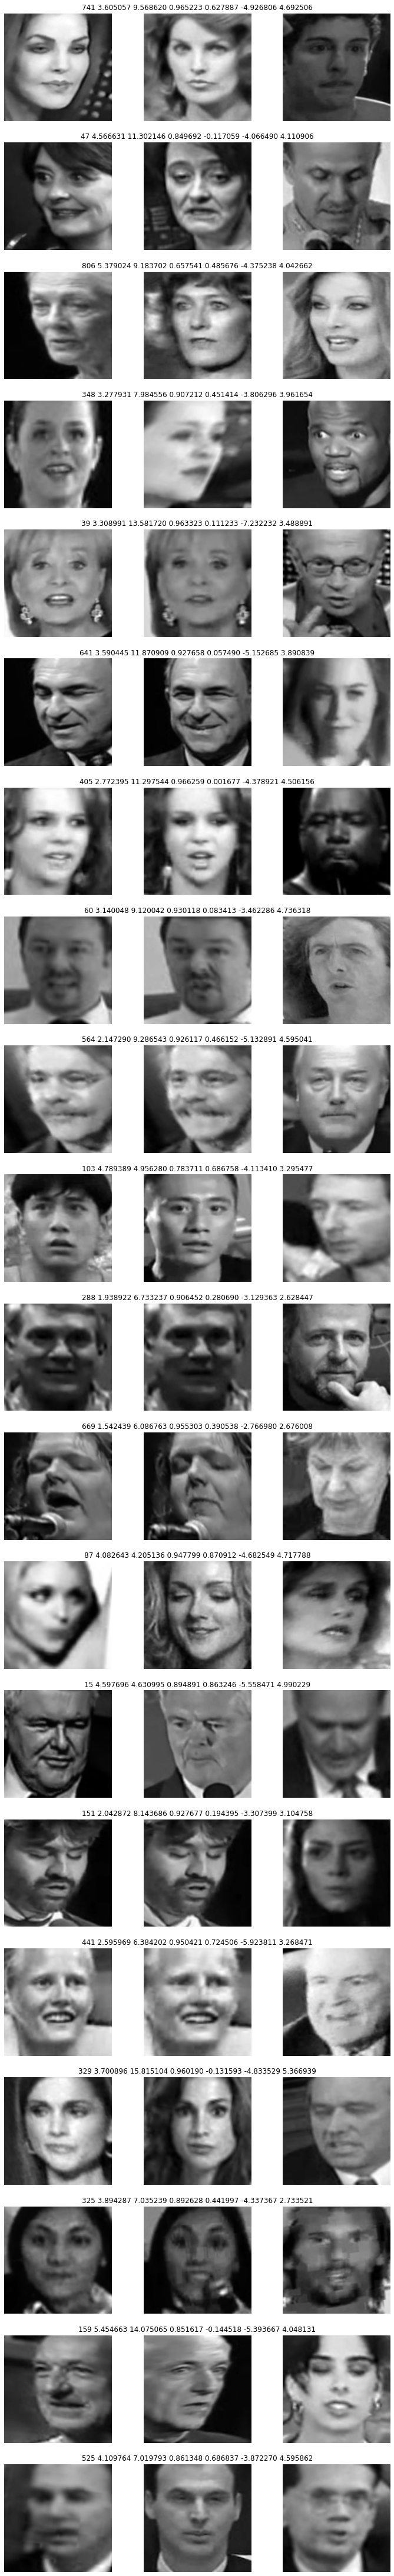

In [20]:
validate('faceid-model-0.016750329740267147.pt')

8.9017834e-05
0.00022181544
9.2187125e-05
0.00011313758
0.00031947182
0.0002450557
0.00019216082
9.404927e-05
0.000100816826
0.00022905448


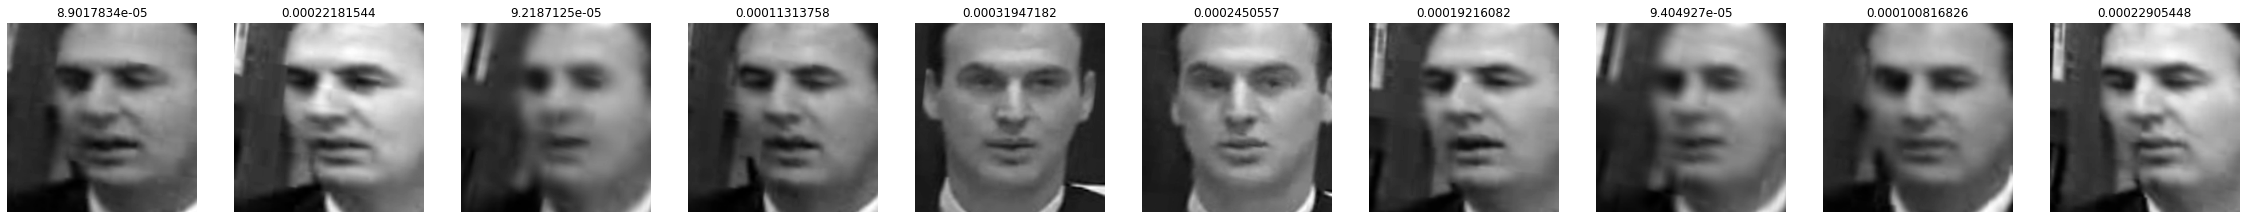

In [23]:
print_sharpness_levels(525)

141 2.995586 8.370061 0.885752 0.428964 -4.254409 3.665482
15 3.373751 17.768888 0.954570 -0.463868 -7.327888 4.760590
704 1.997531 8.208906 0.978103 0.467264 -4.467169 4.400675
527 3.231881 5.888353 0.947956 0.814367 -4.812459 4.498525
501 2.631477 5.624761 0.918112 0.727982 -3.405783 2.911058
730 2.238341 6.444371 0.956218 0.588280 -5.595697 2.604564
249 3.864035 10.676549 0.870066 -0.097276 -3.432198 3.492193
626 2.257627 4.150366 0.971234 0.892236 -4.225925 3.932573
452 1.569311 10.607396 0.983778 0.464959 -5.937195 4.328935
418 2.321843 10.327678 0.948725 0.174293 -4.755079 2.937300
388 2.997331 14.276099 0.911377 -0.197525 -4.113206 3.884107
540 3.113300 7.623677 0.948226 0.559799 -4.329848 3.730487
536 1.688339 9.326466 0.978624 0.228023 -4.744776 2.975206
250 3.494261 6.151155 0.928268 0.756304 -4.782039 3.865540
270 3.518769 14.174685 0.928147 -0.231534 -4.992610 4.896407
675 5.359365 5.564652 0.719438 0.777886 -5.158215 3.234059
271 3.901204 4.986283 0.777103 0.816420 -4.3037

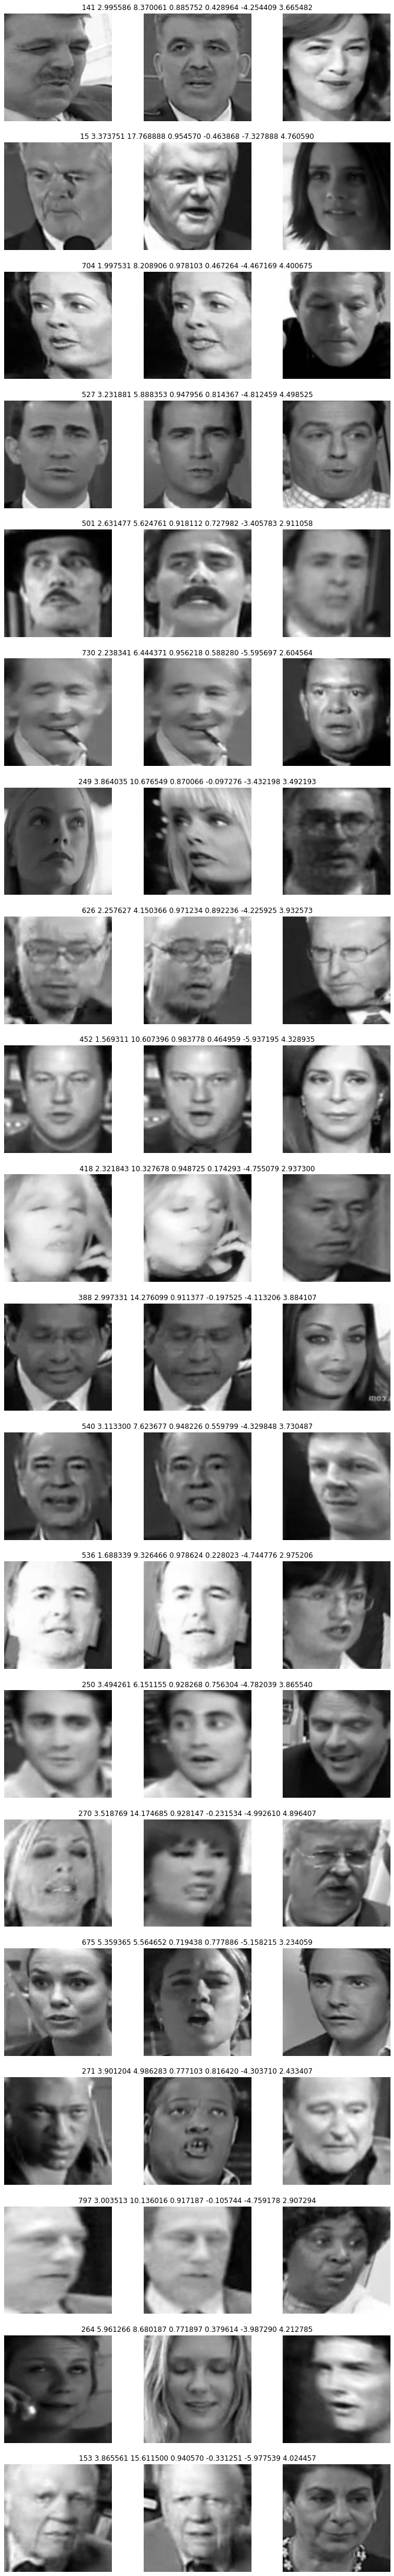

In [21]:
validate('faceid-model-0.02253507034381968.pt')

760 2.233727 7.368136 0.973140 0.620326 -5.599637 4.112329
793 3.511553 4.218811 0.951662 0.894570 -6.322705 5.117218
716 4.107132 13.934662 0.914520 -0.333555 -5.181272 4.247349
256 3.970478 4.768736 0.835480 0.797179 -4.370395 3.558035
440 3.303669 6.651778 0.941206 0.324540 -4.275415 2.473717
459 3.372071 6.749573 0.908806 0.706898 -5.572176 3.455477
87 4.676585 6.273150 0.915115 0.801097 -4.770051 4.058304
393 1.754418 16.454874 0.995464 -0.224025 -6.745126 5.287537
300 6.966110 8.572035 0.909403 0.775548 -4.739754 7.766633
79 2.365215 20.000095 0.981165 -0.338112 -6.341785 4.990799
229 2.791350 13.577584 0.953296 -0.018336 -4.953008 3.045671
226 3.741064 15.236686 0.900820 -0.319314 -5.038437 4.500115
512 8.073082 11.154268 0.648883 0.053401 -4.989505 4.845567
205 3.699950 11.361791 0.863841 0.171693 -6.304718 4.116835
5 4.733672 7.017164 0.923993 0.521198 -4.664382 5.227797
24 1.341627 8.239571 0.993865 0.717816 -6.550684 5.564472
250 3.558553 10.312259 0.966888 0.543746 -4.70706

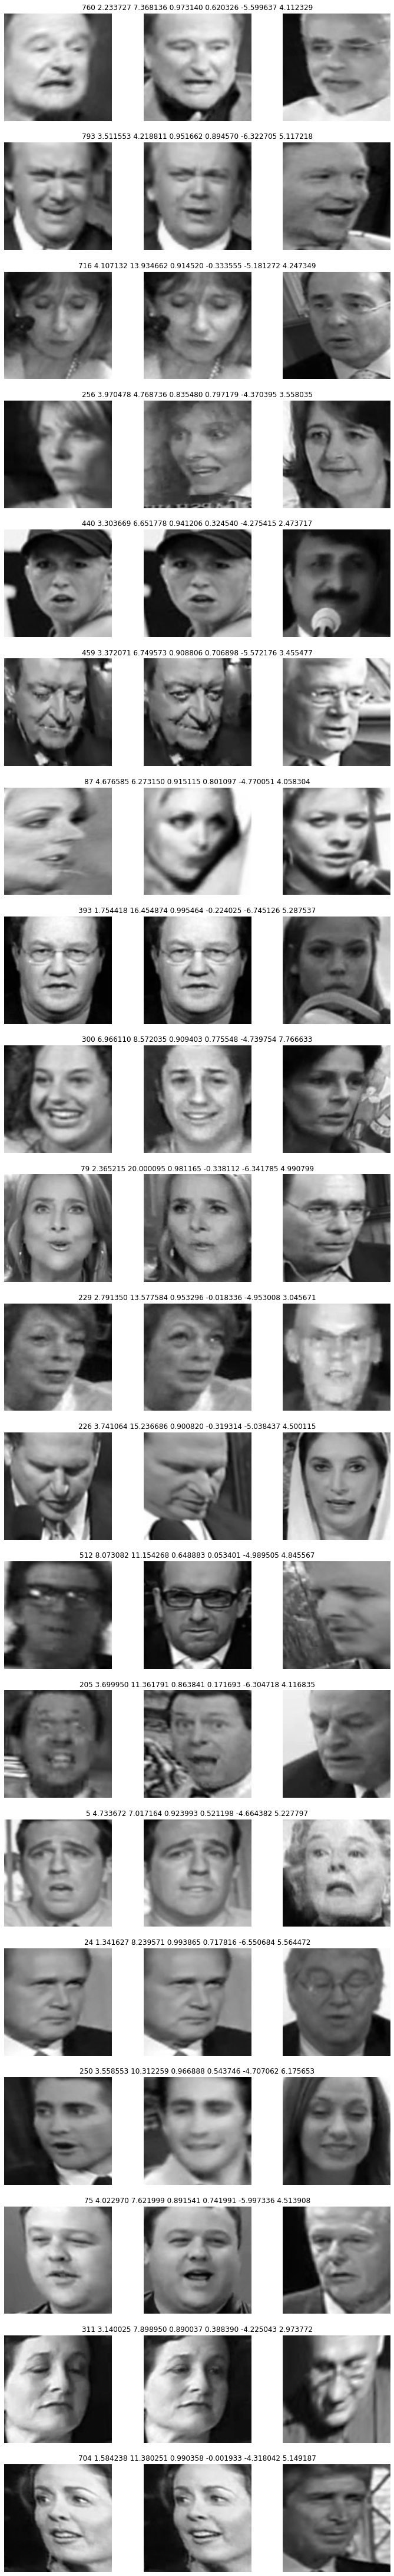

In [22]:
validate('faceid-model-0.011796065969605762.pt')